Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=110.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:04<00:00, 3952.76it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:50<00:00,  5.74it/s]


第0个epoch的学习率：0.000009
Train Loss: 388.755157


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.24it/s]


right_point = 
0.8187682064086559
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.71it/s]


第1个epoch的学习率：0.000006
Train Loss: 262.625580


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.22it/s]


right_point = 
0.8418643362463587
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:55<00:00,  5.69it/s]


第2个epoch的学习率：0.000005
Train Loss: 257.955994


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.17it/s]


right_point = 
0.8439450686641697
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:57<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.101868


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.16it/s]

right_point = 
0.8245942571785269


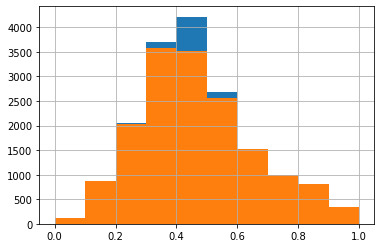

In [1]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=110.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=120.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:04<00:00, 3341.43it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:52<00:00,  5.72it/s]


第0个epoch的学习率：0.000009
Train Loss: 395.381683


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.22it/s]


right_point = 
0.787973366625052
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:53<00:00,  5.71it/s]


第1个epoch的学习率：0.000006
Train Loss: 263.020630


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.19it/s]


right_point = 
0.8393674573449854
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:55<00:00,  5.70it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.122681


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.15it/s]


right_point = 
0.83832709113608
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:56<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.438690


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.15it/s]

right_point = 
0.8250104036620891


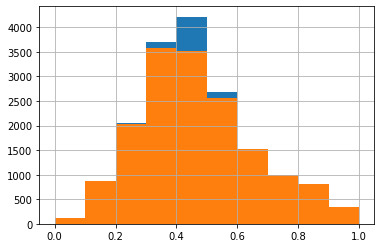

In [2]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=120.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=130.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:05<00:00, 3115.68it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:51<00:00,  5.72it/s]


第0个epoch的学习率：0.000009
Train Loss: 392.810272


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.23it/s]


right_point = 
0.7942155638784852
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:53<00:00,  5.71it/s]


第1个epoch的学习率：0.000006
Train Loss: 263.355438


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.18it/s]


right_point = 
0.8272992093216812
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.70it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.540161


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.16it/s]


right_point = 
0.8408239700374532
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:57<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.713120


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.11it/s]

right_point = 
0.8202247191011236


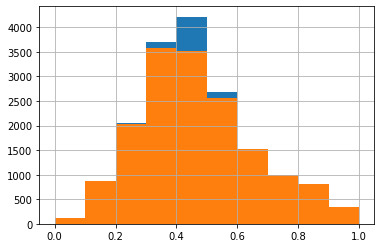

In [3]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=130.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=140.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:05<00:00, 3069.34it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:52<00:00,  5.72it/s]


第0个epoch的学习率：0.000009
Train Loss: 396.548401


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.22it/s]


right_point = 
0.8168955472326259
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.70it/s]


第1个epoch的学习率：0.000006
Train Loss: 263.652130


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.19it/s]


right_point = 
0.8339575530586767
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:55<00:00,  5.70it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.196716


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.15it/s]


right_point = 
0.8433208489388264
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:57<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.321701


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.14it/s]

right_point = 
0.8264669163545568


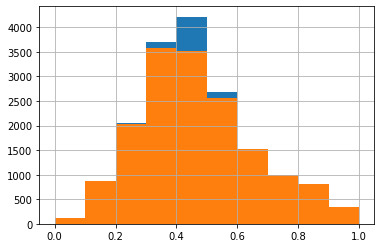

In [4]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=140.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=160.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:05<00:00, 3037.58it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:52<00:00,  5.72it/s]


第0个epoch的学习率：0.000009
Train Loss: 392.458313


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.23it/s]


right_point = 
0.8104452767374116
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.71it/s]


第1个epoch的学习率：0.000006
Train Loss: 263.404785


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.19it/s]


right_point = 
0.8356221389929255
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:55<00:00,  5.70it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.247101


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.15it/s]


right_point = 
0.8393674573449854
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:57<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.469742


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.14it/s]

right_point = 
0.8216812317935913


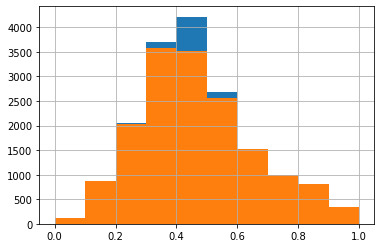

In [5]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=160.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=170.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:05<00:00, 3039.33it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:52<00:00,  5.72it/s]


第0个epoch的学习率：0.000009
Train Loss: 399.908936


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.19it/s]


right_point = 
0.8100291302538494
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.71it/s]


第1个epoch的学习率：0.000006
Train Loss: 263.285126


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.19it/s]


right_point = 
0.8360382854764877
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:55<00:00,  5.70it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.376404


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.16it/s]


right_point = 
0.8458177278401997
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:57<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.424301


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.14it/s]

right_point = 
0.8343736995422388


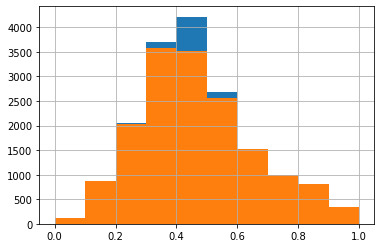

In [6]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=170.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=180.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:05<00:00, 2969.19it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:52<00:00,  5.72it/s]


第0个epoch的学习率：0.000009
Train Loss: 395.573944


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.23it/s]


right_point = 
0.8135663753641281
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.71it/s]


第1个epoch的学习率：0.000006
Train Loss: 262.879517


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.18it/s]


right_point = 
0.8395755305867666
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:54<00:00,  5.70it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.207214


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.15it/s]


right_point = 
0.8478984602580109
epoch 3


100%|███████████████████████████████████████| 4075/4075 [11:56<00:00,  5.68it/s]


第3个epoch的学习率：0.000004
Train Loss: 254.221863


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.13it/s]

right_point = 
0.8252184769038702


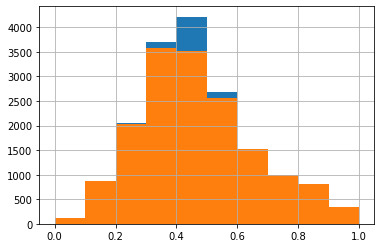

In [7]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=180.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299
Done loading 197 NEZHA weights from: /home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=190.pth. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	module.fc.weight
	module.fc.bias


100%|███████████████████████████████████| 16299/16299 [00:05<00:00, 3188.75it/s]


初始化的学习率： 9e-06
epoch 0


100%|███████████████████████████████████████| 4075/4075 [11:50<00:00,  5.74it/s]


第0个epoch的学习率：0.000009
Train Loss: 398.052979


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.31it/s]


right_point = 
0.8123179359134415
epoch 1


100%|███████████████████████████████████████| 4075/4075 [11:47<00:00,  5.76it/s]


第1个epoch的学习率：0.000006
Train Loss: 262.981720


100%|█████████████████████████████████████████| 301/301 [00:29<00:00, 10.21it/s]


right_point = 
0.8420724094881398
epoch 2


100%|███████████████████████████████████████| 4075/4075 [11:46<00:00,  5.77it/s]


第2个epoch的学习率：0.000005
Train Loss: 258.053986


100%|█████████████████████████████████████████| 301/301 [00:27<00:00, 10.80it/s]


right_point = 
0.8456096545984186
epoch 3


  1%|▏                                        | 22/4075 [00:03<11:40,  5.79it/s]


KeyboardInterrupt: 

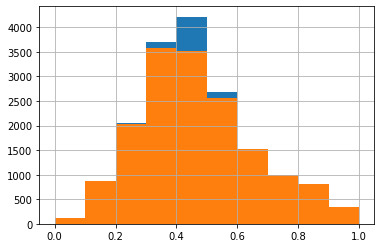

In [8]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=190.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')